Since we are only extrapolating on the time domain, we drop dependencies on other variables and let the PINN learn them.

Hiroyasu & Arai: two asymptotes blended by a sigmoid weight.

$$
S(t) = (1 - w(t)) \, k_v t + w(t) \, k_p \sqrt{t}
$$

Here, the sigmoid weight (sqrt side) is

$$
w(t) = \sigma\!\left(
\frac{t - t_b}{s}
\right) = 
\frac{1}{1+e^{-
\frac{t - t_b}{s}}}
$$

We fit parameters in log-space:

$$
[\ln(k_v),\ \ln(k_p),\ \ln(t_b),\ \ln(s)]
$$

and recover positive parameters by exponentiation in code (with $t_b = e^{\ln(t_b)} + 	ext{min\_tb}$).


For the sigmoid defined above,

$$

\frac{d}{dt} w(t)
= 
\frac{1}{s}

\frac{e^{-\frac{t - t_b}{s}}}

{\left(1+e^{-\frac{t - t_b}{s}}
\right)^2}
= 
\frac{1}{s}\, w(t)\left(1-w(t)
\right)
$$


Using $S(t) = (1-w)k_v t + w k_p \sqrt{t}$, with $w = w(t)$,

$$
S'(t) = k_v(1-w) - k_v t\, w'(t)
+ k_p w'(t)\sqrt{t} + \frac{k_p w(t)}{2\sqrt{t}}
$$

For the sigmoid $w(t)=\sigma((t-t_b)/s)$,

$$
w'(t)=\frac{1}{s}w(1-w),\qquad
w''(t)=\frac{1}{s^2}w(1-w)(1-2w)
$$

Then

$$
S''(t)= -2k_v w'(t) - k_v t\, w''(t)
+ k_p w''(t)\sqrt{t} +\frac{k_p w'(t)}{\sqrt{t}} - \frac{k_p w(t)}{4 t^{3/2}}
$$


In [279]:
import pandas as pd

df = pd.read_csv(r"D:\data\Nozzle1\Nozzle1_test_data.csv")

fps = 25000
# px_mm_scale = df["px2mm_scale"][0] #To be calibrated later
px_mm_scale = 0.24
hydraulic_delay = 16


dataset = "median" # or "median"
USE_STD_WEIGHTS = False

In [280]:
df.shape

(1350, 13)

In [281]:
chunk_size = 50
num_chunks = (len(df) + chunk_size - 1) // chunk_size
chunk_indices = list(range(num_chunks))


In [282]:
import numpy as np


def build_fit_arrays(df_tp):
    t = 1.0 / fps * (df_tp["frame_number"].to_numpy(dtype=float) - hydraulic_delay)

    if dataset == "median":
        y = px_mm_scale * df_tp["penetration_median"].to_numpy(dtype=float)
    elif dataset == "mean":
        y = px_mm_scale * df_tp["penetration_average"].to_numpy(dtype=float)
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    if "penetration_std" in df_tp.columns and USE_STD_WEIGHTS:
        sigma = df_tp["penetration_std"].to_numpy(dtype=float)
        sigma = np.where(
            np.isfinite(sigma) & (sigma > 1e-9),
            sigma,
            np.nanmedian(sigma[np.isfinite(sigma) & (sigma > 0)])
        )
    else:
        sigma = np.ones_like(y)

    return t, y, sigma


In [283]:
import numpy as np
from scipy.special import expit  # expit(x) = 1 / (1 + exp(-x))

# If you used a lower bound on tb before, keep it here
min_tb = 0.0 # change if you want a strictly positive minimum break time


def spray_penetration_model_sigmoid(params, t):
    """
    params (log-space): [log_c_lin, log_c_sqrt, log_tb, log_s]
        - c_lin  : effective linear-region gain (kv * sqrt(2*delta_p/rho_f))
        - c_sqrt : effective sqrt-region gain (kp * (delta_p/rho_a)**0.25 * sqrt(d))
        - tb     : break time (with lower bound min_tb)
        - s      : transition softness of the sigmoid

    t: array-like or float (time)
    """
    log_c_lin, log_c_sqrt, log_tb, log_s = params

    c_lin = np.exp(log_c_lin)
    c_sqrt = np.exp(log_c_sqrt)
    tb = np.exp(log_tb) + min_tb
    s = np.exp(log_s)

    # numerical guard
    t = np.clip(t, 1e-9, None)

    # Linear and sqrt asymptotes
    linear = c_lin * t
    sqrt_segment = c_sqrt * np.sqrt(t)

    # Sigmoid weight from sqrt side; (1-w) weights the linear side
    w = expit((t - tb) / s)

    return (1.0 - w) * linear + w * sqrt_segment


In [284]:
from scipy.optimize import least_squares

init = {
    "kv": 1.0,
    "kp": 1.0,
    "tb": 1e-1,
    "s": 1.0,
}
x0 = np.log([init["kv"], init["kp"], init["tb"], init["s"]])


def fit_sigmoid(df_tp, return_arrays=False):
    t, y, sigma = build_fit_arrays(df_tp)

    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        result = {
            "log_params": np.full(4, np.nan),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }
        if return_arrays:
            result["t"] = t
            result["y"] = y
            result["sigma"] = sigma
        return result

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]
        sigma_fit = sigma[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit)
        return (y_hat - y_fit) / sigma_fit

    res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

    log_kv, log_kp, log_tb, log_s = res.x
    result = {
        "log_params": res.x,
        "kv": float(np.exp(log_kv)),
        "kp": float(np.exp(log_kp)),
        "tb": float(np.exp(log_tb) + min_tb),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": int(valid.sum()),
    }

    if return_arrays:
        result["t"] = t
        result["y"] = y
        result["sigma"] = sigma

    return result


In [285]:
results = []

for chunk_idx in chunk_indices:
    start = chunk_idx * chunk_size
    df_tp_chunk = df.iloc[start:start + chunk_size]
    if df_tp_chunk.empty:
        continue

    fit = fit_sigmoid(df_tp_chunk)
    fit["chunk_idx"] = chunk_idx
    fit["start_row"] = start
    fit["end_row"] = start + len(df_tp_chunk) - 1
    fit["y_avg"] = df_tp_chunk["penetration_average"].to_numpy(dtype=float)
    fit["y_median"] = df_tp_chunk["penetration_median"].to_numpy(dtype=float)
    results.append(fit)

fit_results = pd.DataFrame(results)

if fit_results.empty:
    print("No chunks to fit.")
else:
    print(f"Fit done for {len(fit_results)} chunks.")
    print(f"Success rate: {fit_results['success'].mean():.3f}")

fit_results.head()


Fit done for 27 chunks.
Success rate: 0.963


,log_params,kv,kp,tb,s,cost,success,n,chunk_idx,start_row,end_row,y_avg,y_median
0,"[-3.946358145406637, 7.991787172181001, -9.178...",0.019325,2956.576151,0.000103,0.000138,21.291010,True,37,0,0,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[-7.819650414765284, 8.098180295888582, -9.160...",0.000402,3288.478569,0.000105,0.000228,10.992515,True,31,1,50,99,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-6.027583027023347, 8.07151730675396, -9.5304...",0.002411,3201.956495,0.000073,0.000166,18.872492,True,34,2,100,149,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-4.221114576428236, 8.149368933757422, -9.235...",0.014682,3461.194133,0.000097,0.000177,21.925048,True,34,3,150,199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-5.510469236012639, 8.44921860094166, -8.3703...",0.004044,4671.421065,0.000232,0.000344,15.119572,True,30,4,200,249,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Example fit (chunk 12 )
kv=63263.9, kp=3602.93, tb=1.09e-05 ms, s=0.00262826
cost: 51.775603187577815 success: True


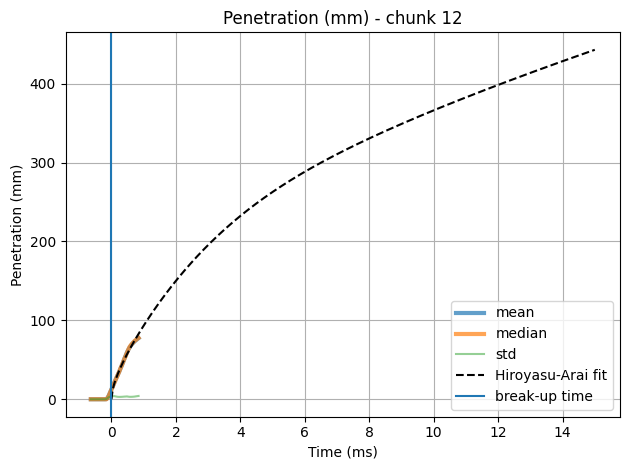

In [286]:
example_chunk = 12
df_tp = df.iloc[example_chunk * chunk_size:(example_chunk + 1) * chunk_size].copy()

example_fit = fit_sigmoid(df_tp, return_arrays=True)
log_kv, log_kp, log_tb, log_s = example_fit["log_params"]
kv = example_fit["kv"]
kp = example_fit["kp"]
tb = example_fit["tb"]
s = example_fit["s"]

print("Example fit (chunk", example_chunk, ")")
print(f"kv={kv:.6g}, kp={kp:.6g}, tb={1e3*tb:.3g} ms, s={s:.6g}")
print("cost:", example_fit["cost"], "success:", example_fit["success"])

import matplotlib.pyplot as plt

frames = 125
frame_n = np.linspace(0, frames, frames + 1)
t_s = 1 / fps * frame_n

t_ms = 1e3 / fps * (df_tp["frame_number"] - hydraulic_delay)
t_ms_np = t_ms.to_numpy(dtype=float)

triple_ts = np.linspace(t_s[0], 3 * t_s[-1], 3 * len(t_s))


plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_average"],
    label="mean",
    linewidth=3,
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_median"],
    label="median",
    linewidth=3,
    alpha=0.7
)
plt.plot(
    t_ms_np,
    px_mm_scale * df_tp["penetration_std"],
    label="std",
    alpha=0.5
)

# Plot fitted curve using seconds (model expects SI units), x-axis stays in ms.
plt.plot(
    triple_ts * 1e3,
    spray_penetration_model_sigmoid([log_kv, log_kp, log_tb, log_s], triple_ts),
    "k--",
    linewidth=1.5,
    label="Hiroyasu-Arai fit"
)


plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.title(f"Penetration (mm) - chunk {example_chunk}")
plt.axvline(1e3 * tb, label="break-up time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


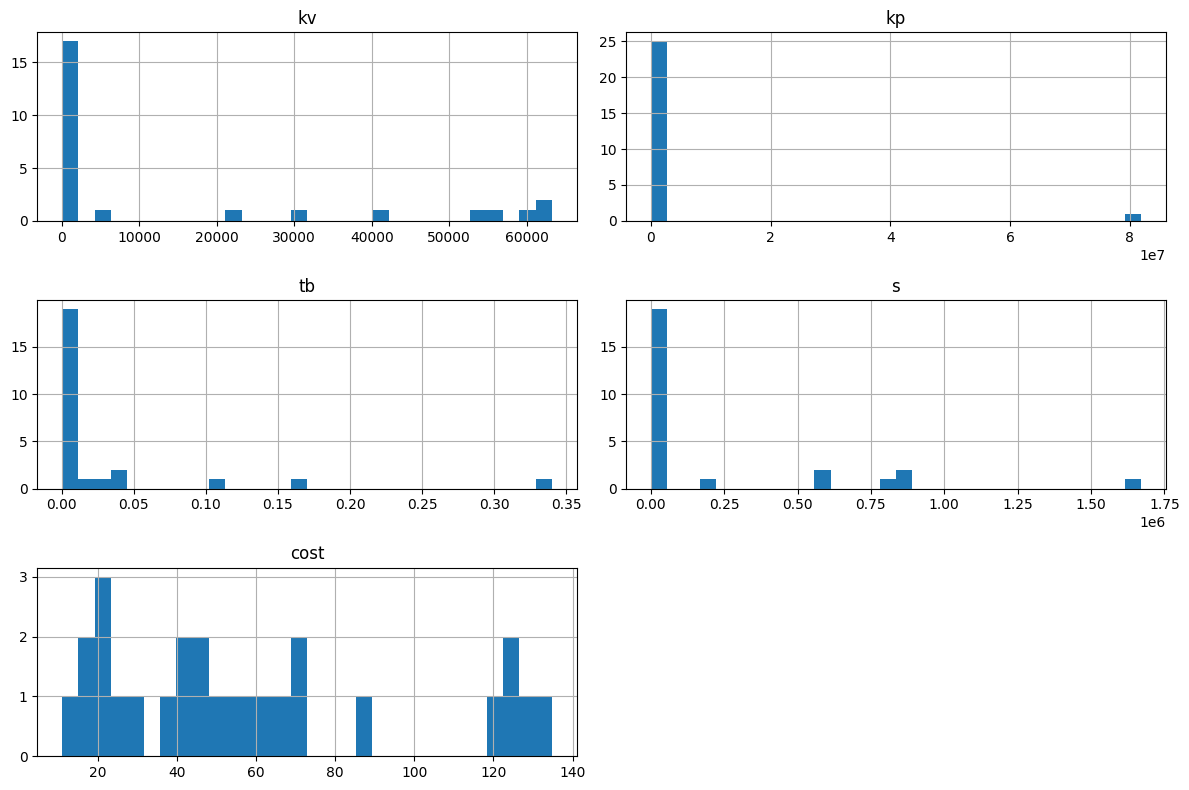

In [287]:
cols = ["kv", "kp", "tb", "s", "cost"]
fit_ok = fit_results[fit_results["success"]].copy()

if fit_ok.empty:
    print("No successful fits to summarize.")
else:
    fit_ok[cols].hist(bins=30, figsize=(12, 8))
    plt.tight_layout()
    plt.show()
    fit_ok[cols].describe()


Text(0, 0.5, 'tb Value (ms)')

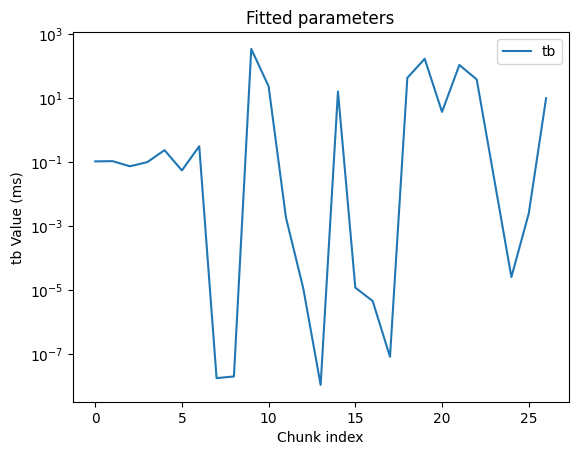

In [288]:
start = 0 
end = start + 27
# plt.plot(fit_ok["kv"][start:end], label="kv")
# plt.plot(fit_ok["kp"][start:end], label="kp")
plt.semilogy(1e3* fit_ok["tb"][start:end], label="tb")
# plt.semilogy(fit_ok["s"][start:end], label="s")
plt.legend()
plt.title("Fitted parameters")
plt.xlabel("Chunk index")
plt.ylabel("tb Value (ms)")

(0.0, 300.0)

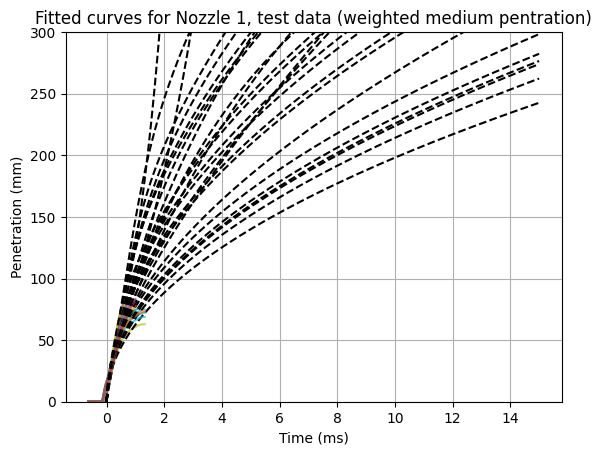

In [289]:
start = 0
end = start + 26
for i in range(start, end):
    log_kv = np.log(fit_ok["kv"].iloc[i])
    log_kp = np.log(fit_ok["kp"].iloc[i])
    log_tb = np.log(fit_ok["tb"].iloc[i] - min_tb)
    log_s = np.log(fit_ok["s"].iloc[i])

    plt.plot(
        t_ms_np,
        fit_ok["y_median"].iloc[i] * px_mm_scale,
        label="median",
        linewidth=1.5,
        alpha=0.7
    )



    # Plot fitted curve using seconds (model expects SI units), x-axis stays in ms.
    
    plt.plot(
        triple_ts * 1e3,
        spray_penetration_model_sigmoid([log_kv, log_kp, log_tb, log_s],
                                         triple_ts),
        "k--",
        linewidth=1.5,
        label="Hiroyasu-Arai fit"
    )
plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.grid()
plt.title("Fitted curves for Nozzle 1, test data (weighted medium pentration)")
plt.ylim(0, 300)

In [290]:
fit_ok.head()

,log_params,kv,kp,tb,s,cost,success,n,chunk_idx,start_row,end_row,y_avg,y_median
0,"[-3.946358145406637, 7.991787172181001, -9.178...",0.019325,2956.576151,0.000103,0.000138,21.291010,True,37,0,0,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[-7.819650414765284, 8.098180295888582, -9.160...",0.000402,3288.478569,0.000105,0.000228,10.992515,True,31,1,50,99,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-6.027583027023347, 8.07151730675396, -9.5304...",0.002411,3201.956495,0.000073,0.000166,18.872492,True,34,2,100,149,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[-4.221114576428236, 8.149368933757422, -9.235...",0.014682,3461.194133,0.000097,0.000177,21.925048,True,34,3,150,199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-5.510469236012639, 8.44921860094166, -8.3703...",0.004044,4671.421065,0.000232,0.000344,15.119572,True,30,4,200,249,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Penalized fits (monotone + concave)

We refit the same sigmoid model, but add soft penalties for $S'(t) < 0$ and $S''(t) > 0$ on a time window $0 < t < 15\,\mathrm{ms}$.


In [302]:
# Penalized refit: discourage S'(t) < 0 and S''(t) > 0 on a time window

penalty_t_min = 1e-6
penalty_t_max = 5e-3
penalty_points = 10
penalty_t = np.linspace(penalty_t_min, penalty_t_max, penalty_points)

lambda_slope = 1.0
lambda_curv = 1.0


def sigmoid_w(t, tb, s):
    return expit((t - tb) / s)


def sigmoid_w_prime(w, s):
    return (1.0 / s) * w * (1.0 - w)


def sigmoid_w_double_prime(w, s):
    return (1.0 / (s * s)) * w * (1.0 - w) * (1.0 - 2.0 * w)


def s_prime(t, kv, kp, tb, s):
    w = sigmoid_w(t, tb, s)
    wp = sigmoid_w_prime(w, s)
    return kv * (1.0 - w) - kv * t * wp + kp * wp * np.sqrt(t) + (kp * w) / (2.0 * np.sqrt(t))


def s_double_prime(t, kv, kp, tb, s):
    w = sigmoid_w(t, tb, s)
    wp = sigmoid_w_prime(w, s)
    wpp = sigmoid_w_double_prime(w, s)
    return (
        -2.0 * kv * wp - kv * t * wpp
        + kp * wpp * np.sqrt(t) + (kp * wp) / np.sqrt(t) - (kp * w) / (4.0 * t ** 1.5)
    )


def fit_sigmoid_penalized(df_tp):
    t, y, sigma = build_fit_arrays(df_tp)

    valid = np.isfinite(t) & np.isfinite(y) & np.isfinite(sigma) & (sigma > 0)
    if not np.any(valid):
        return {
            "log_params": np.full(4, np.nan),
            "kv": np.nan,
            "kp": np.nan,
            "tb": np.nan,
            "s": np.nan,
            "cost": np.inf,
            "success": False,
            "n": 0,
        }

    def residuals(params):
        t_fit = t[valid]
        y_fit = y[valid]
        sigma_fit = sigma[valid]

        y_hat = spray_penetration_model_sigmoid(params, t_fit)
        data_res = (y_hat - y_fit) / sigma_fit

        log_kv, log_kp, log_tb, log_s = params
        kv = float(np.exp(log_kv))
        kp = float(np.exp(log_kp))
        tb = float(np.exp(log_tb) + min_tb)
        s = float(np.exp(log_s))

        sp = s_prime(penalty_t, kv, kp, tb, s)
        spp = s_double_prime(penalty_t, kv, kp, tb, s)

        penalty_slope = np.sqrt(lambda_slope) * np.maximum(0.0, -sp)
        penalty_curv = np.sqrt(lambda_curv) * np.maximum(0.0, spp)

        return np.concatenate([data_res, penalty_slope, penalty_curv])

    res = least_squares(residuals, x0, method="trf", loss="huber", f_scale=1.0)

    log_kv, log_kp, log_tb, log_s = res.x
    return {
        "log_params": res.x,
        "kv": float(np.exp(log_kv)),
        "kp": float(np.exp(log_kp)),
        "tb": float(np.exp(log_tb) + min_tb),
        "s": float(np.exp(log_s)),
        "cost": float(res.cost),
        "success": bool(res.success),
        "n": int(valid.sum()),
    }


pen_results = []

for chunk_idx in chunk_indices:
    start = chunk_idx * chunk_size
    df_tp_chunk = df.iloc[start:start + chunk_size]
    if df_tp_chunk.empty:
        continue

    fit = fit_sigmoid_penalized(df_tp_chunk)
    fit["chunk_idx"] = chunk_idx
    fit["start_row"] = start
    fit["end_row"] = start + len(df_tp_chunk) - 1
    pen_results.append(fit)

pen_fit_results = pd.DataFrame(pen_results)

if pen_fit_results.empty:
    print("No chunks to fit (penalized).")
else:
    print(f"Penalized fit done for {len(pen_fit_results)} chunks.")
    print(f"Success rate: {pen_fit_results['success'].mean():.3f}")

# pen_fit_results.head()


Penalized fit done for 27 chunks.
Success rate: 1.000


### Penalized fit curves (overlay)


(-0.5, 2.0)

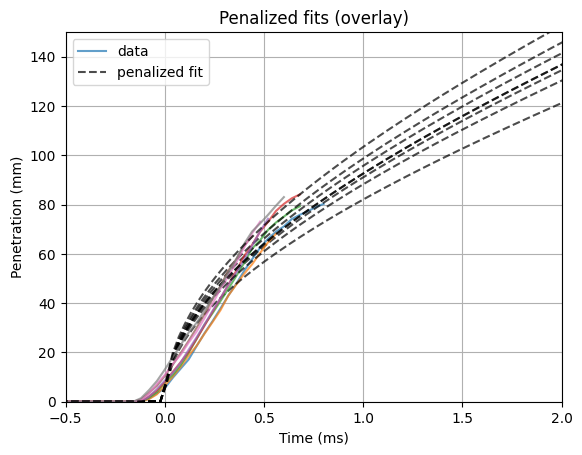

In [303]:
# Overlay penalized fits
[0, 8, 17]
start = 0
end = min(start + 8, len(pen_fit_results))

for i in range(start, end):
    kv = pen_fit_results["kv"].iloc[i]
    kp = pen_fit_results["kp"].iloc[i]
    tb = pen_fit_results["tb"].iloc[i]
    s = pen_fit_results["s"].iloc[i]

    df_tp_chunk = df.iloc[i * chunk_size:(i + 1) * chunk_size]
    t, y, _ = build_fit_arrays(df_tp_chunk)
    t_ms = 1e3 * t
    triple_ts = np.linspace(t.min(), 3 * t.max(), 3 * len(t))

    label_data = "data" if i == start else None
    label_fit = "penalized fit" if i == start else None

    plt.plot(
        t_ms,
        y,
        label=label_data,
        linewidth=1.5,
        alpha=0.7
    )

    plt.plot(
        triple_ts * 1e3,
        spray_penetration_model_sigmoid(
            [np.log(kv), np.log(kp), np.log(tb - min_tb), np.log(s)],
            triple_ts
        ),
        "k--",
        linewidth=1.5,
        alpha=0.7,
        label=label_fit
    )

plt.xlabel("Time (ms)")
plt.ylabel("Penetration (mm)")
plt.grid()
plt.title("Penalized fits (overlay)")
plt.ylim(0, 150)
plt.legend()
plt.xlim(-0.5,2)

